## Notebook to generate collision rate violators for any RMG job while running

In [1]:
import logging
import numpy as np
import os
import sys

In [2]:
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path not in sys.path:
    sys.path.append(rmg_path)
sys.path

import rmgpy
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmgobject import RMGObject, expand_to_dict, recursive_make_object

print(f"RMG-Py Version {rmgpy.__version__}")
print(rmgpy.__file__)

RDKit WARNING: [17:17:33] Enabling RDKit 2019.09.1 jupyter extensions


RMG-Py Version 3.0.0
/scratch/ajulu.c/Code/RMG-Py/rmgpy/__init__.py


In [5]:
chemkin_file = '../nc10_lowT/chemkin/chem_annotated.inp'
chemkin_folder = os.path.split(chemkin_file)[0]
species_dictionary_file = os.path.join(chemkin_folder, 'species_dictionary.txt')
transport_file = os.path.join(chemkin_folder, 'tran.dat')

In [6]:
species, reactions = rmgpy.chemkin.load_chemkin_file(
                    chemkin_file, species_dictionary_file,transport_path=transport_file,
                    check_duplicates=False, use_chemkin_names=True,read_comments=True)



ValueError: invalid literal for int() with base 10: '<<<<<<<'

In [5]:
species_dict = {rmgpy.chemkin.get_species_identifier(s): s for s in species}
species_dict.keys()

dict_keys(['N2', 'Ar', 'Ne', 'nC10H22(1)', 'O2(2)', 'CH(3)', 'C2H(4)', 'O(5)', 'CO(6)', 'CO2(7)', 'H2O(8)', 'CH2O(9)', 'CH4(10)', 'C2H4(11)', 'C3H6(12)', 'H2(13)', 'R_1(14)', 'R_2(15)', 'R_3(16)', 'R_4(17)', 'R_5(18)', 'ROO_1(19)', 'ROO_2(20)', 'ROO_3(21)', 'ROO_4(22)', 'ROO_5(23)', 'QOOH_1(24)', 'QOOH_2(25)', 'QOOH_3(26)', 'QOOH_4(27)', 'QOOH_5(28)', 'QOOH_6(29)', 'QOOH_7(30)', 'QOOH_8(31)', 'QOOH_9(32)', 'S(33)', 'S(34)', 'S(35)', 'S(36)', 'S(37)', 'S(38)', 'S(39)', 'S(40)', 'S(41)', 'S(42)', 'S(43)', 'S(44)', 'S(45)', 'S(46)', 'S(47)', 'S(48)', 'S(49)', 'S(50)', 'S(51)', 'S(52)', 'S(53)', 'S(54)', 'S(55)', 'S(56)', 'S(57)', 'S(58)', 'S(59)', 'S(60)', 'S(61)', 'S(62)', 'S(63)', 'S(64)', 'S(65)', 'S(66)', 'S(67)', 'S(68)', 'S(69)', 'S(70)', 'S(71)', 'S(72)', 'S(73)', 'S(74)', 'S(75)', 'S(76)', 'S(77)', 'S(78)', 'S(79)', 'S(80)', 'S(81)', 'S(82)', 'S(83)', 'S(84)', 'S(85)', 'S(86)', 'S(87)', 'S(88)', 'S(89)', 'S(90)', 'S(91)', 'S(92)', 'S(93)', 'S(94)', 'S(95)', 'S(96)', 'S(97)', 'S(98

In [6]:
len(species), len(reactions)

(805, 28958)

In [7]:
def check_collision_limit_violation(self, t_min, t_max, p_min, p_max):
        """
        Warn if a core reaction violates the collision limit rate in either the forward or reverse direction
        at the relevant extreme T/P conditions. Assuming a monotonic behaviour of the kinetics.
        Returns a list with the reaction object and the direction in which the violation was detected.
        """
        conditions = [[t_min, p_min]]
        if t_min != t_max:
            conditions.append([t_max, p_min])
        if self.kinetics.is_pressure_dependent() and p_max != p_min:
            conditions.append([t_min, p_max])
            if t_min != t_max:
                conditions.append([t_max, p_max])
        logging.debug("Checking whether reaction {0} violates the collision rate limit...".format(self))
        violator_list = []
        kf_list = []
        kr_list = []
        collision_limit_f = []
        collision_limit_r = []
        for condition in conditions:
            if len(self.reactants) >= 2:
                try:
                    collision_limit_f.append(self.calculate_coll_limit(temp=condition[0], reverse=False))
                except ValueError:
                    continue
                else:
                    kf_list.append(self.get_rate_coefficient(condition[0], condition[1]))
            if len(self.products) >= 2:
                try:
                    collision_limit_r.append(self.calculate_coll_limit(temp=condition[0], reverse=True))
                except ValueError:
                    continue
                else:
                    kr_list.append(self.generate_reverse_rate_coefficient().get_rate_coefficient(condition[0], condition[1]))
        if len(self.reactants) >= 2:
            for i, k in enumerate(kf_list):
                if k > collision_limit_f[i]:
                    ratio = k / collision_limit_f[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'forward', ratio, condition])
        if len(self.products) >= 2:
            for i, k in enumerate(kr_list):
                if k > collision_limit_r[i]:
                    ratio = k / collision_limit_r[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'reverse', ratio, condition])
        return violator_list

In [8]:
import numpy as np
np.linalg.LinAlgError

numpy.linalg.linalg.LinAlgError

In [9]:
violators = []
for r in reactions:
    try:
        v = check_collision_limit_violation(r, 500,1000, 1e5, 30e5)
    except np.linalg.LinAlgError:
        print(f"LinAlgError checking {r}")
    if v:
        print(r)
        violators.extend(v)

H(261) + HO2(264) <=> H2O2(265)
CH3(268) <=> H2(13) + CH(3)
CH3(268) <=> H(261) + CH2(269)
CH2(269) <=> H(261) + CH(3)
CH2(269) <=> H2(13) + C(279)
C2H2(280) <=> H(261) + C2H(4)
C2O(300) <=> C(279) + CO(6)
HO2(264) + S(303) => O2(2) + CH2OH(272) + CH3O2(282)
CH2O(9) + S(303) => HCO(267) + CH2OH(272) + CH3O2(282)
CH3CO(304) + C2H5(277) <=> C2H4(11) + C2H4O(284)
CH3CO(304) + C5H11(674) <=> C2H4O(284) + C5H10(676)
CH3O(273) + CH3CO(304) <=> CH2O(9) + C2H4O(284)
CH3CO(304) + CH3CO(304) <=> CH2CO(276) + C2H4O(284)
OCHCO(308) + CH3CO(304) <=> CH2CO(276) + S(295)
HOCO(266) + CH3CO(304) <=> HOCHO(306) + CH2CO(276)
HCO(267) + CH3CO(304) <=> CH2O(9) + CH2CO(276)
CH3CO(304) + C2H5O(302) <=> C2H4O(289) + C2H4O(284)
OCHCO(308) + C2H5O(302) <=> S(295) + C2H4O(289)
HOCO(266) + C2H5O(302) <=> HOCHO(306) + C2H4O(289)
CH3O(273) + OCHCO(308) <=> CH2O(9) + S(295)
OCHCO(308) + C2H5(277) <=> S(295) + C2H4(11)
OCHCO(308) + C5H11(674) <=> S(295) + C5H10(676)
HOCO(266) + CH3O(273) <=> CH2O(9) + HOCHO(306)
HOCO

In [10]:
from rmgpy.data.kinetics import TemplateReaction, LibraryReaction
from rmgpy.rmg.pdep import PDepReaction

In [11]:
violators.sort(key = lambda violator: -violator[2])

Text(0.5, 0, 'reaction index (of 28958 total)')

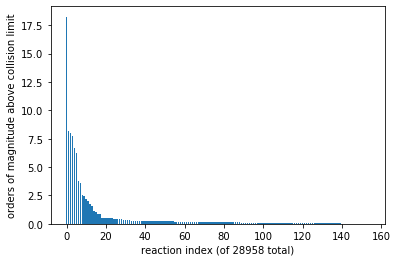

In [12]:
ratios = [np.log10(violator[2]) for violator in violators]
from matplotlib import pyplot as plt
plt.bar(np.arange(len(ratios)), ratios)
plt.ylabel("orders of magnitude above collision limit")
plt.xlabel(f"reaction index (of {len(reactions)} total)")

In [13]:
len(ratios), len(reactions)

(155, 28958)

In [14]:
for violator in violators[:100]:
    rxn_string = str(violator[0])
    direction = {'forward':'=>','reverse':'<='}[violator[1]]
    ratio = violator[2]
    print(f"{rxn_string.replace('<=>',direction) :48s}  {ratio :.1g}")

CH2O(9) + S(303) => HCO(267) + CH2OH(272) + CH3O2(282)  2e+18
CH3(268) <= H(261) + CH2(269)                     1e+08
HO2(264) + S(303) => O2(2) + CH2OH(272) + CH3O2(282)  9e+07
CH3(268) <= H2(13) + CH(3)                        6e+07
CH3(268) <= H(261) + CH2(269)                     5e+06
CH3(268) <= H2(13) + CH(3)                        2e+06
CH3OO(275) + C4H6O(518) => CH4O2(281) + CH2CO(276) + C2H3(278)  5e+03
C2H2(280) <= H(261) + C2H(4)                      4e+03
CH2(269) <= H(261) + CH(3)                        3e+02
HO2(264) + C4H6O(518) => H2O2(265) + CH2CO(276) + C2H3(278)  3e+02
C2H2(280) <= H(261) + C2H(4)                      1e+02
CH2O(9) + S(303) => HCO(267) + CH2OH(272) + CH3O2(282)  1e+02
CH3(268) <= H(261) + CH2(269)                     5e+01
CH3(268) <= H2(13) + CH(3)                        4e+01
OH(262) + C3H5(350) => H(261) + H(261) + C3H4O(330)  1e+01
CH2(269) <= H(261) + CH(3)                        1e+01
C2O(300) <= C(279) + CO(6)                        8
C2H2(280

In [15]:
from collections import Counter
import re

CH2O(9) + S(303) => HCO(267) + CH2OH(272) + CH3O2(282)
Arrhenius(A=(41000,'cm^3/(mol*s)'), n=2.5, Ea=(10.206,'kcal/mol'), T0=(1,'K'))
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.8e+18
Violation condition: 500 K, 1.0 bar




CH3(268) <=> H(261) + CH2(269)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.5e+08
Violation condition: 500 K, 30.0 bar




HO2(264) + S(303) => O2(2) + CH2OH(272) + CH3O2(282)
Arrhenius(A=(2.5e+11,'cm^3/(mol*s)'), n=0, Ea=(-1.49,'kcal/mol'), T0=(1,'K'))
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 9.3e+07
Violation condition: 500 K, 1.0 bar




CH3(268) <=> H2(13) + CH(3)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 5.7e+07
Violation condition: 500 K, 30.0 bar




CH3(268) <=> H(261) + CH2(269)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 4.9e+06
Violation condition: 500 K, 1.0 bar




CH3(268) <=> H2(13) + CH(3)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.9e+06
Violation condition: 500 K, 1.0 bar




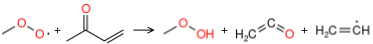

CH3OO(275) + C4H6O(518) => CH4O2(281) + CH2CO(276) + C2H3(278)
Arrhenius(A=(3.01e+12,'cm^3/(mol*s)'), n=0, Ea=(17.58,'kcal/mol'), T0=(1,'K'))
Kinetic library: CurranPentane
Direction: reverse
Violation factor: 5.5e+03
Violation condition: 500 K, 1.0 bar




C2H2(280) <=> H(261) + C2H(4)
ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 4.2e+03
Violation condition: 500 K, 30.0 bar




CH2(269) <=> H(261) + CH(3)
ThirdBody(arrheniusLow=Arrhenius(A=(5.6e+15,'cm^3/(mol*s)'), n=0, Ea=(89,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 3.4e+02
Violation condition: 500 K, 30.0 bar




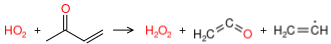

HO2(264) + C4H6O(518) => H2O2(265) + CH2CO(276) + C2H3(278)
Arrhenius(A=(8.5e+12,'cm^3/(mol*s)'), n=0, Ea=(20.46,'kcal/mol'), T0=(1,'K'))
Kinetic library: CurranPentane
Direction: reverse
Violation factor: 2.6e+02
Violation condition: 500 K, 1.0 bar




C2H2(280) <=> H(261) + C2H(4)
ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.4e+02
Violation condition: 500 K, 1.0 bar




CH2O(9) + S(303) => HCO(267) + CH2OH(272) + CH3O2(282)
Arrhenius(A=(41000,'cm^3/(mol*s)'), n=2.5, Ea=(10.206,'kcal/mol'), T0=(1,'K'))
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1e+02
Violation condition: 1000 K, 1.0 bar




CH3(268) <=> H(261) + CH2(269)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 52
Violation condition: 1000 K, 30.0 bar




CH3(268) <=> H2(13) + CH(3)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 39
Violation condition: 1000 K, 30.0 bar




OH(262) + C3H5(350) => H(261) + H(261) + C3H4O(330)
PDepArrhenius(pressures=([0.1,1,10],'atm'), arrhenius=[Arrhenius(A=(5.3e+37,'cm^3/(mol*s)'), n=-6.71, Ea=(29.306,'kcal/mol'), T0=(1,'K')), Arrhenius(A=(4.2e+32,'cm^3/(mol*s)'), n=-5.16, Ea=(30.126,'kcal/mol'), T0=(1,'K')), Arrhenius(A=(1.6e+20,'cm^3/(mol*s)'), n=-1.56, Ea=(26.33,'kcal/mol'), T0=(1,'K'))])
Kinetic library: CurranPentane
Direction: reverse
Violation factor: 13
Violation condition: 500 K, 1.0 bar




CH2(269) <=> H(261) + CH(3)
ThirdBody(arrheniusLow=Arrhenius(A=(5.6e+15,'cm^3/(mol*s)'), n=0, Ea=(89,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 11
Violation condition: 500 K, 1.0 bar




C2O(300) <=> C(279) + CO(6)
ThirdBody(arrheniusLow=Arrhenius(A=(2e+15,'cm^3/(mol*s)'), n=0, Ea=(44.2,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 7.8
Violation condition: 500 K, 30.0 bar




C2H2(280) <=> H(261) + C2H(4)
ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 7
Violation condition: 1000 K, 30.0 bar




In [16]:
families = Counter()
templates = Counter()
rate_rules = Counter()
problem_species = Counter()
for violator in violators:
    rxn_string = str(violator[0])
    kinetics = violator[0].kinetics
    comment = ''
    if isinstance(violator[0], TemplateReaction):
        comment = violator[0].kinetics.comment
        violator[0].kinetics.comment = ''  # the comment is printed better when outside of the object
    if isinstance(violator[0], LibraryReaction):
        comment = 'Kinetic library: {0}'.format(violator[0].library)
    if isinstance(violator[0], PDepReaction):
        comment = 'Network #{0}'.format(violator[0].network)
    direction = violator[1]
    ratio = violator[2]
    condition = violator[3]
    
    problem_species.update(violator[0].reactants)
    problem_species.update(violator[0].products)
    
    m = re.search('family: (.*)', comment)
    if m:
        families[m.group(1)] += 1
    n = re.search('rate rule (.*)', comment)
    if n:
        rate_rules[m.group(1) + n.group(1)] += 1
    n = re.search('using template (\S+)', comment)
    if n:
        templates[m.group(1) + n.group(1)] += 1
    
    if ratio < 5:
        continue # only print the big ones!
    
    display(violator[0])
    print('{0}\n{1}\n{2}\nDirection: {3}\nViolation factor: {4:.2g}\n'
                      'Violation condition: {5}\n\n'.format(rxn_string, kinetics, comment, direction,
                                                            ratio, condition))
    if isinstance(violator[0], TemplateReaction):
        # although this is the end of the run, restore the original comment
        violator[0].kinetics.comment = comment

In [17]:
families.most_common(10)

[('Disproportionation', 69)]

In [18]:
# This is what was used
templates.most_common(10)

[('Disproportionation[CO_rad;XH_s_Rrad]', 68),
 ('Disproportionation[CO_pri_rad;XH_s_Rrad]', 1)]

In [19]:
# This is what it was trying to use
rate_rules.most_common(10)

[('Disproportionation[CO_rad/NonDe;Cmethyl_Csrad]', 38),
 ('Disproportionation[CO_rad/OneDe;Cmethyl_Csrad]', 18),
 ('Disproportionation[CO_rad/NonDe;Cmethyl_COrad]', 4),
 ('Disproportionation[CO_rad/NonDe;Cmethyl_Orad]', 4),
 ('Disproportionation[CO_rad/OneDe;Cmethyl_COrad]', 2),
 ('Disproportionation[CO_rad/OneDe;Cmethyl_Orad]', 2),
 ('Disproportionation[CO_pri_rad;Cmethyl_COrad]', 1)]

In [20]:
# Most common species
for s,n in problem_species.most_common(20):
    print(f"{str(s):10s}  {n:3d}  {s.thermo.comment[:40]}")

CH3CO(304)   37  Thermo library: Klippenstein_Glarborg201
HOCO(266)    24  Thermo library: Klippenstein_Glarborg201
HOCHO(306)   24  Thermo library: Klippenstein_Glarborg201
C2H4O(284)   23  Thermo library: Klippenstein_Glarborg201
C3H4O(330)   22  Thermo library: CurranPentane
OCHCO(308)   22  Thermo library: Klippenstein_Glarborg201
S(295)       22  Thermo library: Klippenstein_Glarborg201
C3H3O(331)   20  Thermo library: CurranPentane
C3H5O(333)   20  Thermo library: CurranPentane
C3H6O(332)   20  Thermo library: CurranPentane
S(3841)      19  Thermo group additivity estimation: grou
S(1975)      19  Thermo group additivity estimation: grou
CH2O(9)      16  Thermo library: Klippenstein_Glarborg201
CH2CO(276)   16  Thermo library: Klippenstein_Glarborg201
H(261)       15  Thermo library: BurkeH2O2
IC3H7(349)   12  Thermo library: CurranPentane
C3H6(12)     12  Thermo library: CurranPentane
CH3O(273)    12  Thermo library: Klippenstein_Glarborg201
C2H5(277)    12  Thermo library: Klip

In [21]:
for s,n in problem_species.most_common(10):
    display(s)
    print(s)
    print(s.molecule[0].to_adjacency_list())
    print(s.thermo.comment)
    print('-'*80)

CH3CO(304)
multiplicity 2
1 O u0 p2 c0 {3,D}
2 C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}
3 C u1 p0 c0 {1,D} {2,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {2,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


HOCO(266)
multiplicity 2
1 O u0 p2 c0 {3,S} {4,S}
2 O u0 p2 c0 {3,D}
3 C u1 p0 c0 {1,S} {2,D}
4 H u0 p0 c0 {1,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


HOCHO(306)
1 O u0 p2 c0 {3,S} {5,S}
2 O u0 p2 c0 {3,D}
3 C u0 p0 c0 {1,S} {2,D} {4,S}
4 H u0 p0 c0 {3,S}
5 H u0 p0 c0 {1,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


C2H4O(284)
1 O u0 p2 c0 {3,D}
2 C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}
3 C u0 p0 c0 {1,D} {2,S} {7,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {2,S}
7 H u0 p0 c0 {3,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


C3H4O(330)
1 O u0 p2 c0 {4,D}
2 C u0 p0 c0 {3,D} {4,S} {5,S}
3 C u0 p0 c0 {2,D} {6,S} {7,S}
4 C u0 p0 c0 {1,D} {2,S} {8,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {3,S}
7 H u0 p0 c0 {3,S}
8 H u0 p0 c0 {4,S}

Thermo library: CurranPentane
--------------------------------------------------------------------------------


OCHCO(308)
multiplicity 2
1 O u1 p2 c0 {3,S}
2 O u0 p2 c0 {4,D}
3 C u0 p0 c0 {1,S} {4,D} {5,S}
4 C u0 p0 c0 {2,D} {3,D}
5 H u0 p0 c0 {3,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


S(295)
1 O u0 p2 c0 {3,D}
2 O u0 p2 c0 {4,D}
3 C u0 p0 c0 {1,D} {4,S} {5,S}
4 C u0 p0 c0 {2,D} {3,S} {6,S}
5 H u0 p0 c0 {3,S}
6 H u0 p0 c0 {4,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


C3H3O(331)
multiplicity 2
1 O u0 p2 c0 {4,D}
2 C u0 p0 c0 {3,D} {4,S} {5,S}
3 C u0 p0 c0 {2,D} {6,S} {7,S}
4 C u1 p0 c0 {1,D} {2,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {3,S}
7 H u0 p0 c0 {3,S}

Thermo library: CurranPentane
--------------------------------------------------------------------------------


C3H5O(333)
multiplicity 2
1 O u0 p2 c0 {4,D}
2 C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}
3 C u0 p0 c0 {2,S} {7,S} {8,S} {9,S}
4 C u1 p0 c0 {1,D} {2,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {2,S}
7 H u0 p0 c0 {3,S}
8 H u0 p0 c0 {3,S}
9 H u0 p0 c0 {3,S}

Thermo library: CurranPentane
--------------------------------------------------------------------------------


C3H6O(332)
1  O u0 p2 c0 {4,D}
2  C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}
3  C u0 p0 c0 {2,S} {7,S} {8,S} {9,S}
4  C u0 p0 c0 {1,D} {2,S} {10,S}
5  H u0 p0 c0 {2,S}
6  H u0 p0 c0 {2,S}
7  H u0 p0 c0 {3,S}
8  H u0 p0 c0 {3,S}
9  H u0 p0 c0 {3,S}
10 H u0 p0 c0 {4,S}

Thermo library: CurranPentane
--------------------------------------------------------------------------------


In [31]:
for violator in violators:
    ratio = violator[2]
    if ratio < 2:
        continue 
    print(ratio)
    new_factors = np.zeros_like(ratio)
#     for i in ratio:
#         new_factors[i] = np.divide(ratio[i],ratio[i])
#     print(new_factors)
        
    

1.7936745517993183e+18
145960912.30518755
92882392.29975204
57090076.573488854
4865363.743506252
1903002.5524496287
5480.433157820036
4207.688788408307
337.9976842585792
262.10074987086506
140.25629294694357
104.24879716223445
51.944041929471744
39.41012689101107
12.913823626794013
11.266589475285976
7.7939611265362565
7.046346495033403
3.2985436995077504
3.2521619670813053
3.202153623155689
3.079822393493384
2.9914479266057814
2.9378152174242342
2.919719921437391
2.7628691459729
2.6301929997699784
2.5451186968639385
2.4479494945593245
2.3329286085822925
2.2977070545405835
2.257324341393118
2.058839885328779


In [33]:
new_factors = np.zeros_like(ratio)
print(new_factors)

0.0
